In [56]:

import matplotlib.pyplot as plt
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

ImportError: cannot import name '_get_container_adapter' from 'sklearn.utils._set_output' (/Users/immanuelbayu/Library/Python/3.9/lib/python/site-packages/sklearn/utils/_set_output.py)

In [57]:
dataset = pd.read_csv('../data/Indonesian Sentiment Twitter Dataset Labeled.csv',sep='\t')
dataset

,sentimen,Tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...
...,...,...
10801,1,Jangan membandingkan kehidupanmu dengan kehidu...
10802,0,Sini uname lu ntar gua follow
10803,1,Apapun yg telah kamu lakukan apapun kesalahanm...
10804,1,3 cara untuk ingat semula apa yang kita dah ha...


In [58]:
alay_dict = pd.read_csv("../data/new_kamusalay.csv", encoding = 'latin-1', header=None)
alay_dict = alay_dict.rename(columns=  {0: 'original',
                                        1: 'replacement'})
stopword_dict = pd.read_csv('../data/stopwordbahasa.csv', header=None)
stopword_dict = stopword_dict.rename(columns={0: 'stopword'})

In [59]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#lowercase
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('((@[^\s]+)|(#[^\s]+))',' ',text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = lowercase(text) # 1
    text = remove_unnecessary_char(text) # 2
    text = remove_nonaplhanumeric(text) # 3
    text = normalize_alay(text) # 4
    text = remove_stopword(text) # 5
    text = stemming(text) # 6
    return text

In [60]:
X = dataset['Tweet'].apply(preprocess)
X

0        lagu bosan save nih huhuhuhuhuhuhuhuhuhuuuuuuu...
1                      lanjut diam menge i sama libat hati
2        doa rezeki putus inna ha zaa larizquna mak lah...
3                             terima kasih hasil 99 9 sisa
4        paham jenis orang malaysia erti nak sangkut ho...
                               ...                        
10801              banding hidup hidup orang milik karunia
10802                                 nama guna gue follow
10803            apa laku apa salah temu maaf hati botkece
10804                                              3 hafal
10805    moga allah mudah urus amp orang keliling stres...
Name: Tweet, Length: 10806, dtype: object

In [61]:
max_features = 1000
max_len=50
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, padding='post', maxlen=max_len)
X.shape

(10806, 50)

In [62]:
sentiment_encode = {-1 : 0, 0 : 1, 1 : 2}
y = dataset['sentimen'].map(sentiment_encode).values
print(dataset['sentimen'])
print(y)

0       -1
1       -1
2        1
3        1
4       -1
        ..
10801    1
10802    0
10803    1
10804    1
10805    1
Name: sentimen, Length: 10806, dtype: int64
[0 0 2 ... 2 2 2]


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7348, 50) (7348, 3)
(1621, 50) (1621, 3)


In [66]:
vocab_size = 5000
embedding_size = 32
epochs=100
learning_rate = 0.05
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.SGD.

In [65]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy'])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=2)

NameError: name 'model' is not defined

In [51]:
def create_model(embed_dim = 16, hidden_unit = 16, dropout_rate = 0.2, optimizers = RMSprop, learning_rate = 0.001):
    model = Sequential()
    model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_train.shape[1]))
    model.add(LSTM(units = hidden_unit, activation = 'tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers(lr = learning_rate), metrics = ['accuracy'])
    print(model.summary())
    return model

In [52]:
model = KerasClassifier(build_fn = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 32,
                        hidden_unit = 32,
                        optimizers = RMSprop,
                        learning_rate = 0.0001,
                   
                        # Fit Parameters
                        epochs=100, 
                        batch_size=64,
                        # Initiate validation data, which is 10% data from data train. It's used for evaluation model
                        validation_split = 0.1)

model_prediction = model.fit(X_train, y_train)

NameError: name 'KerasClassifier' is not defined

NameError: name 'history' is not defined

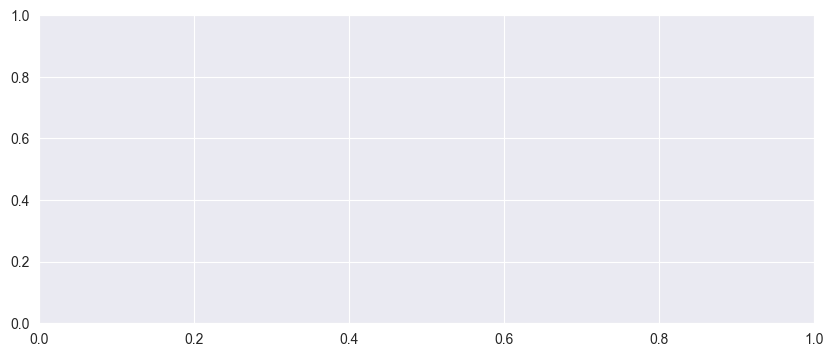

In [53]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(history.history['accuracy'], label = 'train accuracy')
ax.plot(history.history['val_accuracy'], label = 'val accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'upper left')
plt.show()

NameError: name 'model_prediction' is not defined

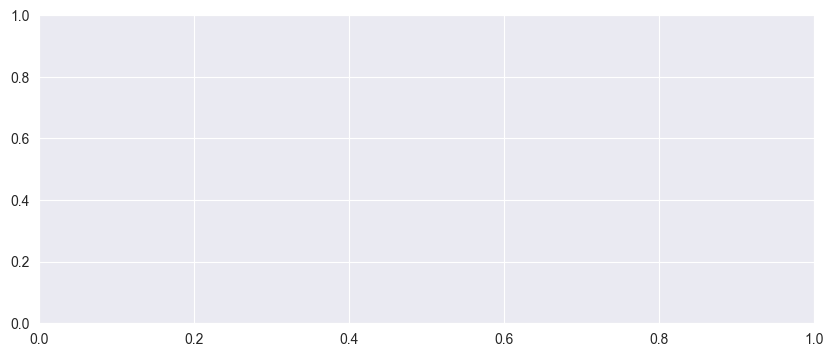

In [54]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(model_prediction.history['loss'], label = 'train loss')
ax.plot(model_prediction.history['val_loss'], label = 'val loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc = 'upper left')
plt.show()